# Generic Code Calibration

In this example we consider a code calibration using a generic or normalized expression of the variables. These equations are normalized so that their means are 1.0, and the analysis includes adjustments for the relative contributions of self-weight ($a_g = G/(G+P)$), other permanent loads, and the imposed or variable loads ($a_q = Q/(G+P+Q)$). In particular, $a_g=1$ means there is no permanent load, and $a_q=1$ means there is only variable load.

The generic design equation is:
$$
    \phi z r_k = (1-a_q) \left[ a_g \gamma_g g_k + (1-a_g) \gamma_p p_k \right] + a_q \gamma_q q_k
$$
from which the design variable $z$ is found as a multiplier of the normalized characteristic resistance, $r_k$, for the normalized characteristic self-weight $g_k$, other permanent loads, $p_k$, and variable loads, $q_k$, using the set of partial factors under examination, $\phi$ for resistance, $\gamma_g$ for self-weight, $\gamma_p$ for other permanent loads, and $\gamma_q$ for variable loads.

The limit state function from which the reliability index of the generic design can be assessed is given by:
$$
    g(z) = \omega_R z R - \omega_S \left[ (1-a_q) \left( a_g G + (1-a_g) P \right) + a_q Q \right]
$$
in which $\omega_R$ and $\omega_S$ are the model uncertainties for resistance and load effects respectively, and the random variables $R$, $G$, $P$, and $Q$, correspond to their characteristic values in the design equation.

This approach has been recently used in the calibration of the second generation of the Eurocodes (Kohler et al2019, Kohler et al 2023).

In [1]:
import pystra as ra
import numpy as np
import matplotlib.pyplot as plt

## Create probility and design models

First we'll create a normalized model to represent 300LA rail loading on a PSC beam in bending.

The model erros define our knowledge about the resistance model and structural analysis accuracy.

In [2]:
ωR = ra.Normal("wR", *1.06*np.array([1.0, 0.05]))
ωS = ra.Lognormal("wS", 1.0, 0.10)

Next, define the resistance information: 
- The design information: the capacity reduction factor and nominal value;
- The probability distribution.

In [3]:
R = ra.Lognormal("R", 1.0,0.08)
Rk = 1/1.08
ϕ = 0.80

And similarly, define the gravity, permanent, and live load values for design and the corresponding probability distributions.

In [4]:
G = ra.Normal("G", 1, 0.08)
Gk = 1/1.03
γ_g = 1.2

P = ra.Normal("P", 1.0,0.10)
Pk = 1.0
γ_p = 1.7    

Q = ra.Normal("Q", 1.0,0.02)
Qk = 1/0.75
γ_q = 1.6

Now assign these to a `GenericModel` object:

In [5]:
pm_current = ra.GenericModel()
pm_current.set_factors(ϕ, γ_g, γ_p, γ_q)
pm_current.set_distributions(ωR, ωS, R, G, P, Q)
pm_current.set_nominals(Rk, Gk, Pk, Qk)

And let's suppose we are interested in exploring a proposal to change the following partial factors:
- $\gamma_q$: from 1.6 to 1.4
- $\gamma_p$: from 1.7 to 1.5

So construct another `GenericModel` object, reusing the previously-defined variables:

In [6]:
pm_proposed = ra.GenericModel()
pm_proposed.set_factors(ϕ, γ_g, 1.5, 1.4)
pm_proposed.set_distributions(ωR, ωS, R, G, P, Q)
pm_proposed.set_nominals(Rk, Gk, Pk, Qk)

## Code Designs Analysis

Now create the `GenericCalibration` object to do the analysis. We want to examine the problem on a grid of points covering the live and dead load ratios as follows:

In [7]:
aq_points = np.arange(0.1,1.1,0.1)
ag_points = np.arange(0.1,1.1,0.1)

In [8]:
rail_load_check = ra.GenericCalibration(aq_points,ag_points)

And add the probability models to the calibration, with some information for plotting.

In [9]:
rail_load_check.add_model(model=pm_current,color='r',label="Current")
rail_load_check.add_model(model=pm_proposed,color='g',label="Proposed")

And do the analysis, then plot, using a reference target reliability of 4.7

In [10]:
rail_load_check.analyse()

And plot the results, passing through plotting arguments as required:

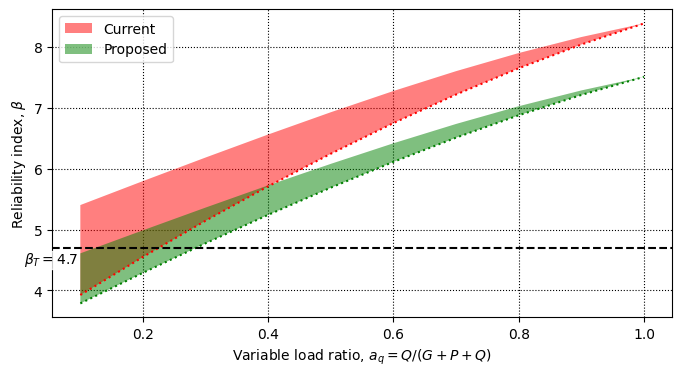

In [11]:
fig,ax = rail_load_check.plot(beta_t=4.7,figsize=(8,4))

Sometimes it is useful to highlight some common ranges of $a_q$ for different forms of construction, and so we can add these to the plot using a specific dictionary format:

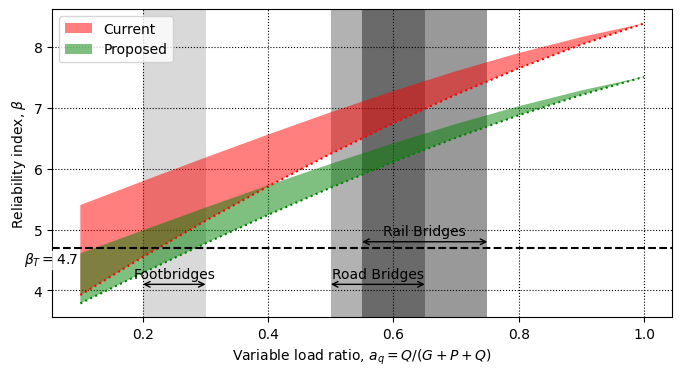

In [12]:
ranges = [
    {'xl':0.2,'xu':0.3,'ytext':4.1,'text':'Footbridges','alpha':0.15},
    {'xl':0.5,'xu':0.65,'ytext':4.1,'text':'Road Bridges','alpha':0.3},
    {'xl':0.55,'xu':0.75,'ytext':4.8,'text':'Rail Bridges','alpha':0.4},
]

fig,ax = rail_load_check.plot(beta_t=4.7,ranges=ranges,figsize=(8,4))

The analysis here suggests that the live loading and load factor is too high (behaviour at $a_q = 1$) and those of the dead and permanent loads are too low (behaviour at low $a_q$). Ideally, the region would be horizontal. The proposed changes do help with live load, but actually make safety worse for low $a_q$.